In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn')

<ipython-input-1-395478a47ca5>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# Model Validation and Selection

In this section, we’ll examine *model evaluation* and the adjustment of *hyperparameters*, which are the parameters set manually, as opposed to the model's regular parameters that are automatically learned from the training data.

### Validating Models:

A crucial aspect of machine learning is **model validation**, which involves assessing how well your model performs with a given dataset. However, there are potential pitfalls to be aware of.

Let's revisit the digits example we've been discussing. How can we evaluate how effectively our model fits the data?

In [2]:
from sklearn.datasets import load_digits

# Load the digits dataset
digits = load_digits()

# Extract features and target labels
X = digits.data
y = digits.target

Let's train a K-neighbors classifier:

It's one of the simplest classifiers: when classifying a point, it examines its K nearest training data points and assigns the label based on a majority vote.

In [4]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize the K-neighbors classifier with 1 neighbor
knn = KNeighborsClassifier(n_neighbors=1)

# Train the classifier with the feature data and target labels
knn.fit(X, y)

KNeighborsClassifier(n_neighbors=1)

Next, we’ll use this classifier to *predict* labels for the data.

In [5]:
y_pred = knn.predict(X)

Finally, we can evaluate the performance of our predictions:

In [6]:
# Count the number of correct predictions
num_correct = len(y[y == y_pred])

# Print the number of correct predictions and the total number of predictions
print(num_correct, '/', len(y), 'correct')


1797 / 1797 correct


It looks like we have a perfect classifier!

**Question: What could be the issue with this?**

### Validation Sets

We made a mistake by evaluating our model on the same dataset used for training. **This is generally not advisable**. Optimizing our estimator this way can lead to **overfitting**: essentially, the model learns the noise rather than the underlying pattern.

A better approach is to use a hold-out set that is not involved in the training process. We’ve previously used scikit-learn’s train/test split utility for this:

**Remember: we should not tune the model using the test data. The train-test split is meant solely for dividing the data into training and validation sets.**

In [8]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y)

# Print the shapes of the training and validation feature sets
X_train.shape, X_valid.shape


((1347, 64), (450, 64))

Now, we’ll train on the training data and validate on the validation data:

In [10]:
# Initialize the K-neighbors classifier with 1 neighbor
knn = KNeighborsClassifier(n_neighbors=1)

# Train the classifier on the training data
knn.fit(X_train, y_train)

# Predict labels for the validation data
y_pred = knn.predict(X_valid)

# Print the number of correct predictions and the total number of validation samples
print(len(y_valid[y_valid == y_pred]), ' / ', len(y_valid), ' correct')

443  /  450  correct


This provides a more reliable assessment of our model's performance.

The metric we're using, which compares the number of correct predictions to the total number of samples, is called the **accuracy score**. This can be calculated using the `model.score()` method.

In [11]:
knn.score(X_valid, y_valid)

0.9844444444444445

Using this approach, we can investigate how the accuracy changes as we adjust the model parameters, such as the number of neighbors:

In [14]:
# Iterate over different values for the number of neighbors
for n_neighbors in [1, 5, 10, 20, 30]:
    # Initialize the K-neighbors classifier with the current number of neighbors
    knn = KNeighborsClassifier(n_neighbors)

    # Train the classifier on the training data
    knn.fit(X_train, y_train)

    # Print the number of neighbors and the accuracy score on the validation data
    print("neighbors: ", n_neighbors, " score: ", knn.score(X_valid, y_valid))

neighbors:  1  score:  0.9844444444444445
neighbors:  5  score:  0.9888888888888889
neighbors:  10  score:  0.98
neighbors:  20  score:  0.9733333333333334
neighbors:  30  score:  0.9644444444444444


In this case, it appears that a smaller number of neighbors yields the best results.

**DISCLAIMER**: Using a validation set will inevitably reduce the amount of data available for training. However, after tuning the model's hyperparameters, we can retrain the model on the combined training and validation data to ensure no information is lost.

### Cross-Validation:

One issue with using validation sets is that it reduces the amount of data available for training. In the example above, we used 3/4 of the data for training and 1/4 for validation. An alternative is to use **2-fold cross-validation**, where we divide the data into two halves and perform validation twice:

In [20]:
# Split the dataset into two equal halves
X1, X2, y1, y2 = train_test_split(X, y, test_size=0.5, random_state=1111)

# Print the shapes of the resulting splits
print("Shape of the two equal halves: ", X1.shape, X2.shape)
print("Performance:")
# Train a K-neighbors classifier on the second half and evaluate on the first half
print(KNeighborsClassifier(1).fit(X2, y2).score(X1, y1))

# Train a K-neighbors classifier on the first half and evaluate on the second half
print(KNeighborsClassifier(1).fit(X1, y1).score(X2, y2))

Shape of the two equal halves:  (898, 64) (899, 64)
Performance:
0.9844097995545658
0.9844271412680756


Thus, two-fold cross-validation provides two estimates of the score for that parameter.

Since performing this manually can be cumbersome, scikit-learn offers a utility function to simplify the process:

In [24]:
from sklearn.model_selection import cross_val_score

# Perform 2-fold cross-validation to evaluate the model
cv = cross_val_score(KNeighborsClassifier(1), X, y, cv=2)

# Print the cross-validation scores
print(cv)

[0.9621802  0.95991091]


### K-fold Cross-Validation:

In the example above, we used 2-fold cross-validation. This is a specific case of $K$-fold cross-validation, where the data is divided into $K$ chunks, and the model is trained $K$ times, with each chunk serving as the validation set once.

We can achieve this by adjusting the `cv` parameter. Let’s perform 10-fold cross-validation:

In [25]:
cross_val_score(KNeighborsClassifier(1), X, y, cv=10)

array([0.93333333, 0.99444444, 0.97222222, 0.97222222, 0.96666667,
       0.98333333, 0.99444444, 0.98882682, 0.97765363, 0.96648045])

This provides a more accurate assessment of how well our model is performing.

## Overfitting, Underfitting, and Choosing the Right Model

Now that we’ve covered the basics of validation and cross-validation, let’s delve deeper into model selection.

The challenges associated with validation and cross-validation are critical aspects of machine learning practice. Choosing the optimal model for your data is crucial and often underappreciated by many practitioners.

A key question to consider is:

**If our model is underperforming, what steps should we take next?**

- Should we opt for a simpler or more complex model?
- Should we increase the amount of training data?

The answers are not always straightforward. In particular, **using a more complex model can sometimes lead to worse results**, and **adding more training data may not always enhance performance**. The ability to determine the right actions to improve your model is what distinguishes successful machine learning practitioners from the rest.

### Understanding the Bias-Variance Tradeoff

In this section, we’ll tackle a straightforward 1D regression problem to clearly visualize both the data and the model. The concepts we discuss here can be extended to higher-dimensional datasets. We will examine a basic **linear regression** scenario using the `sklearn.linear_model` module in scikit-learn.

We’ll start by generating a simple nonlinear function that we aim to fit with our model.

In [26]:
def test_func(x, err=0.5):
    # Define the nonlinear function to fit
    y = 10 - 1. / (x + 0.1)

    # Add Gaussian noise to the function values if err > 0
    if err > 0:
        y = np.random.normal(y, err)  # Apply Gaussian noise around the function

    return y

Let's now generate an instance of this dataset:

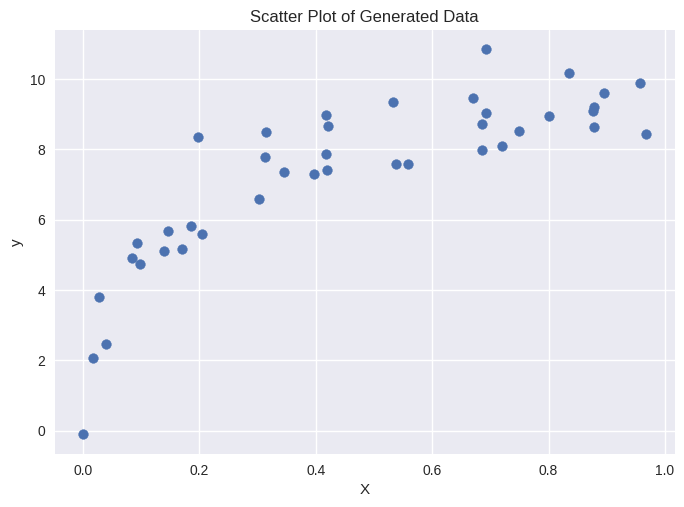

In [28]:
def make_data(N=40, error=1.0, random_seed=1):
    # Set the random seed for reproducibility
    np.random.seed(random_seed)

    # Generate random sample data
    X = np.random.random(N)

    # Generate target values using the test function with added error
    y = test_func(X, error)

    # Reshape X to be a column vector, as scikit-learn expects data in this format
    X = X.reshape(len(X), 1)

    return X, y


# Generate a dataset with 40 samples and an error level of 1
X, y = make_data(40, error=1)

# Create a scatter plot of the data
plt.scatter(X, y)
plt.xlabel('X')
plt.ylabel('y')
plt.title('Scatter Plot of Generated Data')
plt.show()

Now, if we want to perform regression on this data, we can use the built-in linear regression function to compute the fit:

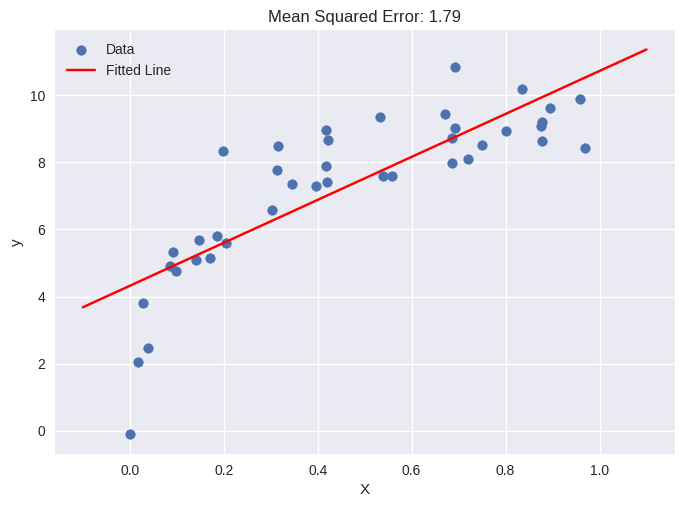

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Generate test data for prediction
X_test = np.linspace(-0.1, 1.1, 500)
X_test = X_test.reshape(len(X_test), 1)

# Initialize and fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Predict the target values for the test data
y_test = model.predict(X_test)

# Plot the original data and the fitted line
plt.scatter(X.ravel(), y, label='Data')
plt.plot(X_test.ravel(), y_test, color='red', label='Fitted Line')
plt.title("Mean Squared Error: {0:.3g}".format(mean_squared_error(model.predict(X), y)))
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()


We have fitted a straight line to the data, but it's evident that this model isn't suitable. We describe this model as **biased** or **underfitting** the data.

To improve the fit, we can use a more complex model by increasing the degrees of freedom and applying polynomial regression to the inputs. Scikit-learn simplifies this process with the `PolynomialFeatures` preprocessor, which can be combined with linear regression in a pipeline.

Let's create a utility function to handle this:

In [30]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2):
    # Create a pipeline with polynomial feature generation and linear regression
    return make_pipeline(
        PolynomialFeatures(degree),  # Transform features to polynomial features
        LinearRegression()           # Apply linear regression to the transformed features
    )

We will now use this to fit a quadratic curve to the data.

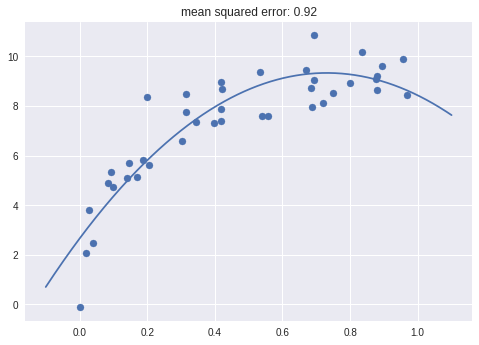

In [ ]:
model = PolynomialRegression(2)
model.fit(X, y)
y_test = model.predict(X_test)

plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(model.predict(X), y)));

This reduces the mean squared error, and makes a much better fit.  What happens if we use an even higher-degree polynomial?

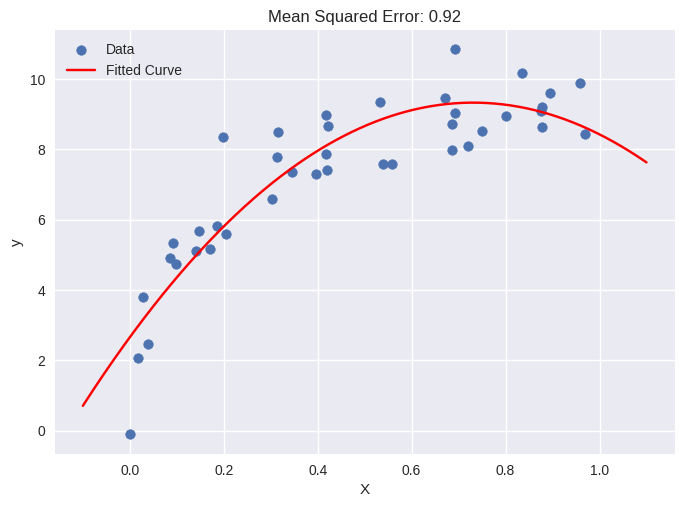

In [31]:
# Initialize and fit the polynomial regression model with degree 2
model = PolynomialRegression(degree=2)
model.fit(X, y)

# Predict the target values for the test data
y_test = model.predict(X_test)

# Plot the original data and the fitted quadratic curve
plt.scatter(X.ravel(), y, label='Data')
plt.plot(X_test.ravel(), y_test, color='red', label='Fitted Curve')
plt.title("Mean Squared Error: {0:.3g}".format(mean_squared_error(model.predict(X), y)))
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()
                              #the first three decimals

Increasing the degree to this extent clearly shows that the resulting fit no longer captures the true underlying distribution but becomes more sensitive to noise in the training data. This is known as a **high-variance model**, and it is said to **overfit** the data.

For a bit of fun, let's use IPython's `interact` feature (available in IPython 2.0+) to explore this interactively:

In [32]:
from IPython.html.widgets import interact
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def plot_fit(degree=1, Npts=50):
    # Generate data with specified number of points and error level
    X, y = make_data(Npts, error=1)

    # Generate test data for prediction
    X_test = np.linspace(-0.1, 1.1, 500)
    X_test = X_test.reshape(len(X_test), 1)

    # Initialize and fit the polynomial regression model with the given degree
    model = PolynomialRegression(degree=degree)
    model.fit(X, y)

    # Predict the target values for the test data
    y_test = model.predict(X_test)

    # Plot the original data and the fitted curve
    plt.scatter(X.ravel(), y)
    plt.plot(X_test.ravel(), y_test)
    plt.ylim(-4, 14)
    plt.title("Mean Squared Error: {0:.2f}".format(mean_squared_error(model.predict(X), y)))
    plt.show()

# Create interactive plot with sliders for degree and number of points
interact(plot_fit, degree=(1, 30), Npts=(2, 100));


/usr/local/lib/python3.10/dist-packages/IPython/html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "


interactive(children=(IntSlider(value=1, description='degree', max=30, min=1), IntSlider(value=50, description…

# Identifying Overfitting with Validation Curves

It's evident that evaluating error solely on the training data is insufficient (as we observed earlier). To better understand model performance, we can use **cross-validation**.

Here, we'll apply the `validation_curve` utility to gain deeper insights. For clarity, we’ll use a slightly larger dataset:

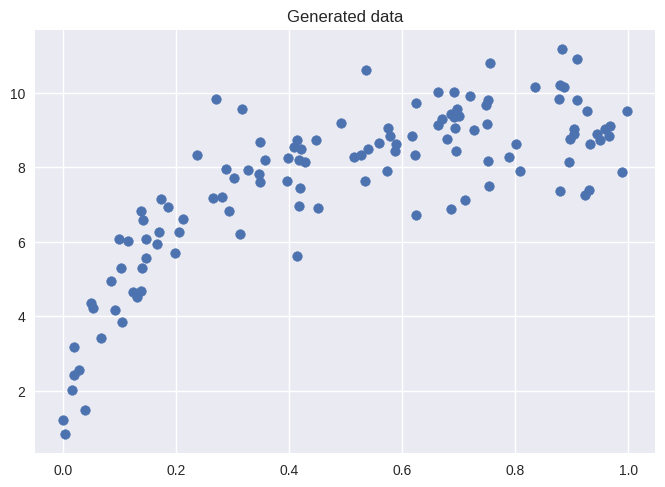

Size of the validation curve output on the test set:  (18, 7)


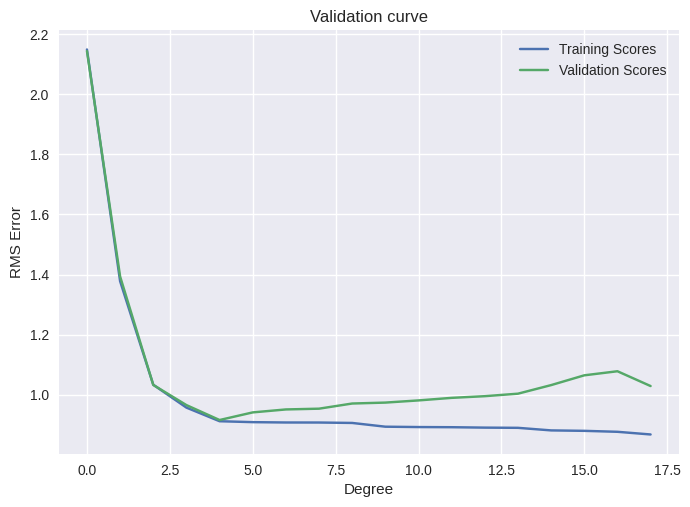

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve

# Generate a larger dataset with 120 samples and an error level of 1.0
X, y = make_data(120, error=1.0)

# Plot the generated data
plt.scatter(X, y)
plt.title("Generated data")
plt.show()

def rms_error(model, X, y):
    # Calculate the root mean squared error for a given model.
    y_pred = model.predict(X)
    return np.sqrt(np.mean((y - y_pred) ** 2))

# Define the range of polynomial degrees to evaluate
degree = np.arange(0, 18)

# Perform validation curve analysis to assess model performance
val_train, val_test = validation_curve(
    PolynomialRegression(), X, y,
    param_name='polynomialfeatures__degree',  # Specify the parameter to vary in the pipeline
    param_range=degree,                      # Range of polynomial degrees
    cv=7,                                    # 7-fold cross-validation
    scoring=rms_error                        # Use the custom RMS error function for scoring
)

# Print the size of the validation errors array
print("Size of the validation curve output on the test set: ", val_test.shape)  # Each of the 18 rows contains validation errors for the 7 folds

# Plot the average training and validation scores for each polynomial degree
plt.plot(degree, val_train.mean(1), label='Training Scores')  # Average training scores across folds
plt.plot(degree, val_test.mean(1), label='Validation Scores')  # Average validation scores across folds
plt.title("Validation curve")
# Label the axes
plt.xlabel('Degree')
plt.ylabel('RMS Error')

# Display the legend
plt.legend()
plt.show()

Observe the trend in this type of plot, which is quite typical:

1. With low model complexity, the training and validation errors are very similar, suggesting that the model is **underfitting** the data. This means the model lacks sufficient complexity to capture the data’s patterns, resulting in a **high-bias** model.

2. As model complexity increases, the training and validation errors start to diverge. This indicates **overfitting**: the model is too flexible and begins to fit the noise in the data rather than the underlying trend, leading to a **high-variance** model.

3. The training score usually improves with increasing model complexity because a more complex model can better fit the training data, including its noise. However, the validation score typically finds an optimal point, which in this case is around 5 terms.

Here is the model that best fits the data according to cross-validation:

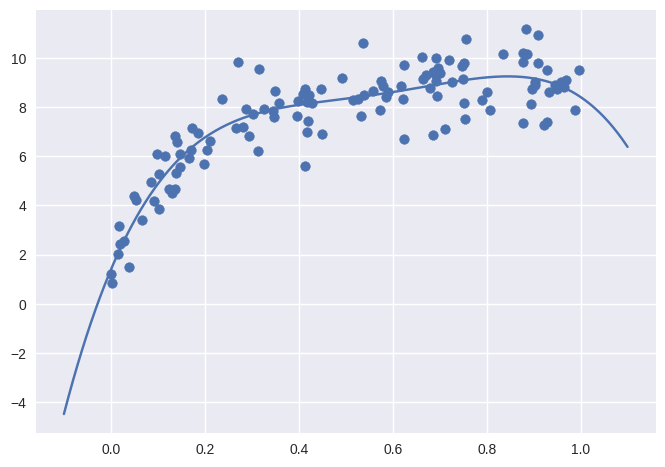

In [45]:
# Fit a polynomial regression model with degree 4 to the data
model = PolynomialRegression(degree=4).fit(X, y)

# Plot the original data
plt.scatter(X, y)

# Plot the polynomial regression curve based on the test data
plt.plot(X_test, model.predict(X_test))
plt.show()

### Evaluating Data Sufficiency with Learning Curves

The optimal balance between bias and variance is closely related to the number of training samples. To illustrate this, we use *learning curves*.

Learning curves plot the mean squared error for both the training set and the test set as a function of the *Number of Training Points*. This helps us understand how the amount of training data impacts model performance.

In [47]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(degree=3):
    # Define the fraction of the total training data to be used at different stages
    train_sizes = np.linspace(0.05, 1, 120)

    # Calculate learning curve data
    train_sizes, train_scores, validation_scores = learning_curve(
        PolynomialRegression(degree),
        X, y,
        train_sizes=train_sizes,
        cv=5,
        scoring=rms_error
    )

    # Plot training scores
    plt.plot(train_sizes, train_scores.mean(axis=1), label='Training Scores')

    # Plot validation scores
    plt.plot(train_sizes, validation_scores.mean(axis=1), label='Validation Scores')

    # Set plot labels and limits
    plt.xlabel('Training Set Size')
    plt.ylabel('RMS Error')
    plt.ylim(0, 3)
    plt.xlim(5, 80)

    # Display the legend
    plt.legend()


Here’s how the learning curves appear for a linear model:

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:1776: RuntimeWarning: Removed duplicate entries from 'train_sizes'. Number of ticks will be less than the size of 'train_sizes': 93 instead of 120.
  warnings.warn(


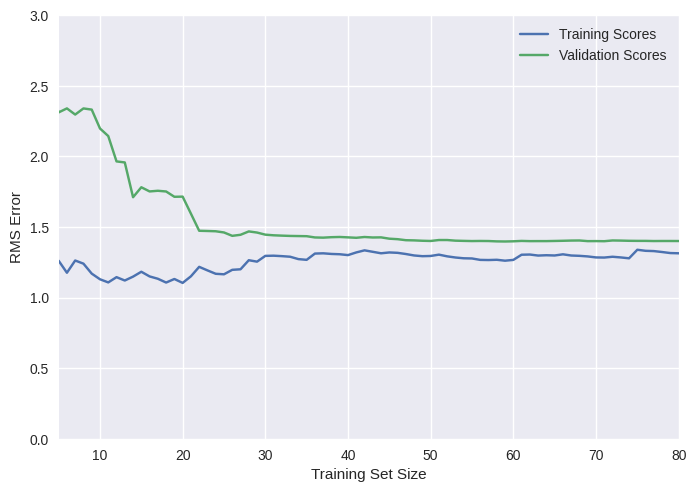

In [48]:
plot_learning_curve(1)

This graph illustrates a typical learning curve. With very few training points, there's a significant gap between training and test error, suggesting **overfitting**. As the number of training points increases, the errors for training and testing converge, which may indicate **underfitting**.

As you add more data points, the training error will not increase, and the test error will not decrease. Why do you think this is the case?

From this plot, it's evident that to reduce the Mean Squared Error (MSE) to the target value of $1.0$ (which represents the amount of noise we introduced when creating the data), adding more samples will not achieve this. For $d = 1$, the two curves have leveled off and cannot go any lower. What happens if we use a larger value for $d$?

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:1776: RuntimeWarning: Removed duplicate entries from 'train_sizes'. Number of ticks will be less than the size of 'train_sizes': 93 instead of 120.
  warnings.warn(


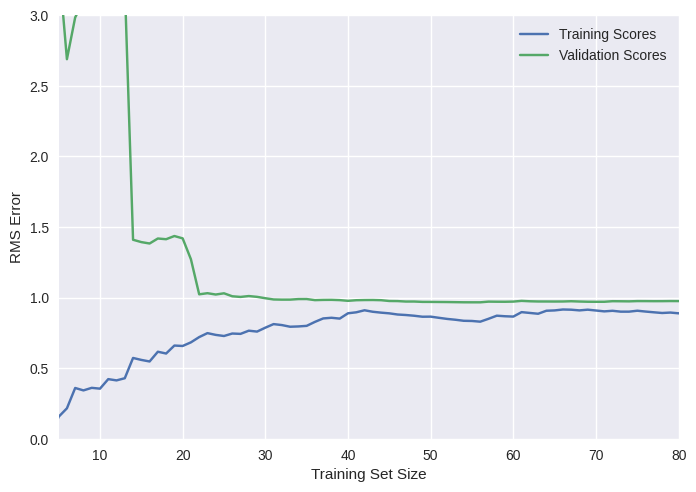

In [49]:
plot_learning_curve(3)

Here, we observe that increasing the model complexity has reduced the convergence RMS error to 1.0.

What happens if we increase the complexity further?

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:1776: RuntimeWarning: Removed duplicate entries from 'train_sizes'. Number of ticks will be less than the size of 'train_sizes': 93 instead of 120.
  warnings.warn(


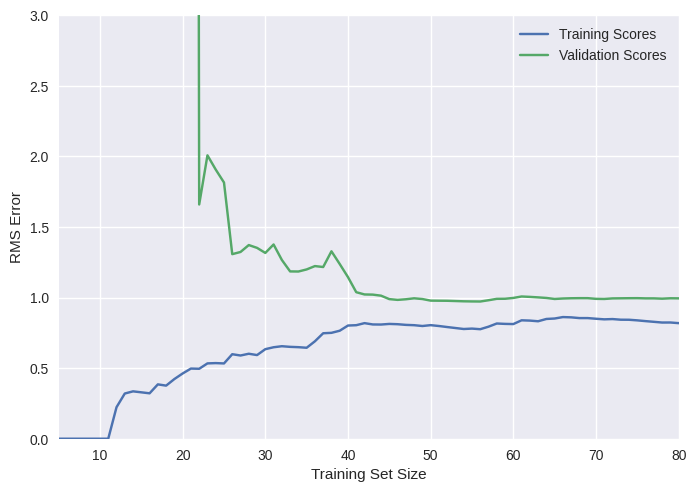

In [50]:
plot_learning_curve(10)

With a more complex model, convergence still occurs, but it only happens with *large* amounts of training data.

In summary:

- To **achieve convergence**, you can either add more data points or simplify the model.
- To **reduce the convergence error**, you need to increase the model's complexity.

These curves can provide insights into improving a sub-optimal model. If the curves are already close together, consider increasing model complexity. If the curves are widely separated, adding more data might enhance the model.

# Out Of Bag Error

When using an ensemble method classifier that employs the Bagging technique (such as Random Forest), there is an error metric called the "Out of Bag" (OOB) error that functions similarly to validation error. The concept is straightforward:

1. Select a data point.
2. Identify all the weak classifiers that did not train on that data point (i.e., the data point is not in their *bag*).
3. Predict the outcome through majority voting among the weak classifiers that did not see the data point.
4. Repeat this process for all data points.
5. The Out of Bag error is the percentage of incorrect predictions.

This approach is advantageous because it evaluates the model on data points that were not used for training. Unlike cross-validation, it utilizes the entire training dataset for hyperparameter tuning.

Next, we'll apply this method to the digit dataset and compare RandomForest classifiers with various `max_depth` values for the weak classifiers (trees).

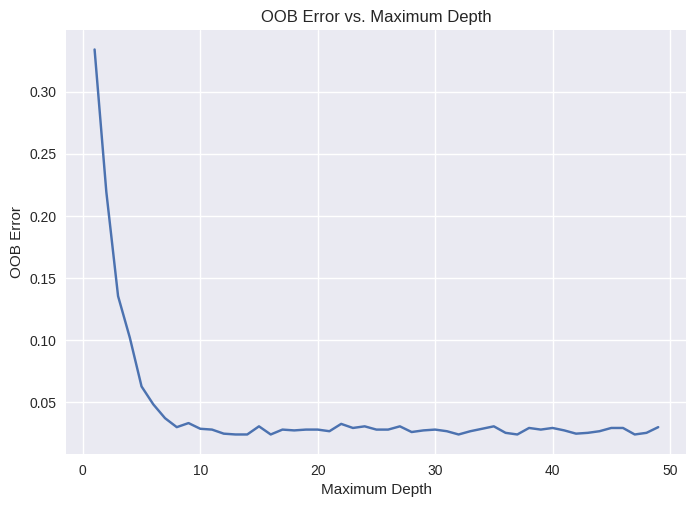

In [51]:
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


# Load the digit dataset
digits = load_digits()
X = digits.data
y = digits.target

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1111)

# Define range for maximum depth values and initialize array for OOB errors
depth_range = np.arange(1, 50)
oob_errors = np.zeros(len(depth_range))

# Train RandomForestClassifier models with different max_depth values and record OOB errors
for i in range(len(depth_range)):
    model = RandomForestClassifier(max_depth=depth_range[i], oob_score=True)
    model.fit(X_train, y_train)
    oob_errors[i] = 1 - model.oob_score_

# Plot the OOB error against the maximum depth
plt.plot(depth_range, oob_errors)
plt.xlabel('Maximum Depth')
plt.ylabel('OOB Error')
plt.title('OOB Error vs. Maximum Depth')
plt.show()

# Note: Why does the behavior not change after a certain maximum depth?
# What might be happening with the weak classifiers?


We can confidently select `max_depth=10`.

Now, let's evaluate the model on the test set:

In [59]:
# Initialize and train the RandomForestClassifier with max_depth=10 and OOB scoring
model = RandomForestClassifier(max_depth=10, oob_score=True)
model.fit(X_train, y_train)

# Evaluate the model on the test set and display the accuracy
test_accuracy = model.score(X_test, y_test)
print(f'Test set accuracy: {test_accuracy:.4f}')

Test set accuracy: 0.9704


## Summary

We have explored several key tools for model validation:

- **Training Score**: Reflects how well a model fits the training data. However, it does not provide a reliable measure of the model's general effectiveness.
  
- **Validation Score**: Measures how well a model performs on unseen hold-out data. The most robust approach is cross-validation, which uses multiple hold-out sets to assess model performance.

- **Validation Curves**: These plots show validation and training scores as a function of **model complexity**:
  + When the curves are close together, it suggests *underfitting*.
  + When the curves are widely separated, it indicates *overfitting*.
  + The ideal scenario is finding a balance where the curves are reasonably close.

- **Learning Curves**: These plots display validation and training scores as a function of the **number of training samples**:
  + When the curves are close, it signals *underfitting*, meaning that adding more data typically won't improve the model.
  + When the curves are far apart, it points to *overfitting*, and adding more data may help improve model performance.

These tools provide valuable insights into evaluating and refining your model’s performance.

**Exercise**

Apply the code: there will be a brief description of learning_curve() and validation_curve(). The exercise is to try to make them work on the logistic regression applied to the breast cancer dataset. For the validation curve the parameter is 'C' (look at sklearn documentation). Do the two plots.



In [ ]:
"""train_sizes, train_scores, valid_scores=learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)

"    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.


    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))"""



In [ ]:
"""train_scores, valid_scores=validation_curve(estimator, X, y, cv=cv, param_name='name',param_range=param_range)

"    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.


    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.


        param_range : array-like, value that the hyperparameter has to assume"""